Objective:
- Lựa chọn tham số (sử dụng cross validation)
- Đánh giá (sử dụng Holdout) và so sánh hai models

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from tqdm import tqdm
from sklearn.datasets import load_files
from pyvi import ViTokenizer
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

In [ ]:
INPUT = 'news_vnexpress'
os.makedirs("images",exist_ok = True)

In [5]:
print('Các nhãn và số văn bản tương ứng trong dữ liệu')
print('----------------------------------------------')
n = 0
for label in os.listdir(INPUT):
    print(f'{label}: {len(os.listdir(os.path.join(INPUT, label)))}')
    n += len(os.listdir(os.path.join(INPUT, label)))
print('-------------------------')
print(f"Tổng số văn bản: {n}")

Các nhãn và số văn bản tương ứng trong dữ liệu
----------------------------------------------
doi-song: 120
du-lich: 54
phap-luat: 59
the-thao: 173
thoi-su: 59
suc-khoe: 162
giai-tri: 201
giao-duc: 105
kinh-doanh: 262
khoa-hoc: 144
-------------------------
Tổng số văn bản: 1339


In [6]:
# Load data
data_train = load_files(container_path=INPUT, encoding="utf-8")
print('mapping:')
for i in range(len(data_train.target_names)):
    print(f'{data_train.target_names[i]}- {i}')
print('--------------------------')
print(data_train.filenames[0:1])
# print(data_train.data[0:1])
print(data_train.target[0:1])
print(data_train.data[0:1])
print("\nTổng số văn bản: {}"
.format( len(data_train.filenames)))

mapping:
doi-song- 0
du-lich- 1
giai-tri- 2
giao-duc- 3
khoa-hoc- 4
kinh-doanh- 5
phap-luat- 6
suc-khoe- 7
the-thao- 8
thoi-su- 9
--------------------------
['news_vnexpress/khoa-hoc/00133.txt']
[4]
['Mời độc giả đặt câu hỏi tại đây\n']

Tổng số văn bản: 1339


## Data Preprocessing

1. Convert data from text into numeric (vectorize by TF)

In [8]:
# load dữ liệu các stopwords
with open("vietnamese-stopwords.txt", encoding="utf-8") as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords]
print(f"Số lượng stopwords: {len(stopwords)}")
print(stopwords[:10])

# Chuyển hoá dữ liệu text về dạng vector TF
# - loại bỏ từ dừng
# - sinh từ điển
module_count_vector = CountVectorizer(stop_words=stopwords)
model_rf_preprocess = Pipeline([('vect', module_count_vector),('tf', TfidfTransformer()),])

# Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận
# Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data, data_train.target)
print(f"\nSố lượng từ trong từ điển: {len(module_count_vector.vocabulary_)}")
print(f"Kích thước dữ liệu sau khi xử lý: {data_preprocessed.shape}")
print(f"Kích thước nhãn tương ứng: {data_train.target.shape}")

Số lượng stopwords: 1942
['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']

Số lượng từ trong từ điển: 12797
Kích thước dữ liệu sau khi xử lý: (1339, 12797)
Kích thước nhãn tương ứng: (1339,)


2. Data Splitting

In [11]:
p = 0.2
pivot = int(data_preprocessed.shape[0] * (1-0.2))
X_train, X_test = data_preprocessed[0:pivot], data_preprocessed[pivot:]
Y_train, Y_test = data_train.target[0:pivot], data_train.target[pivot:]

## Choose optimal Parameters

In [9]:
def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(estimator, X_train, Y_train, cv = 10, n_jobs = -1, train_sizes = [1.0, ], scoring = "accuracy")
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std
def plot(title, xlabel, X, Y, error, ylabel = "Accuracy"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    plt.errorbar(X, Y, error, linestyle = 'None', marker = 'o')

**I. SVM Parameters**

1. Choose kernel for SVM

100%|██████████| 4/4 [00:22<00:00,  5.54s/it]


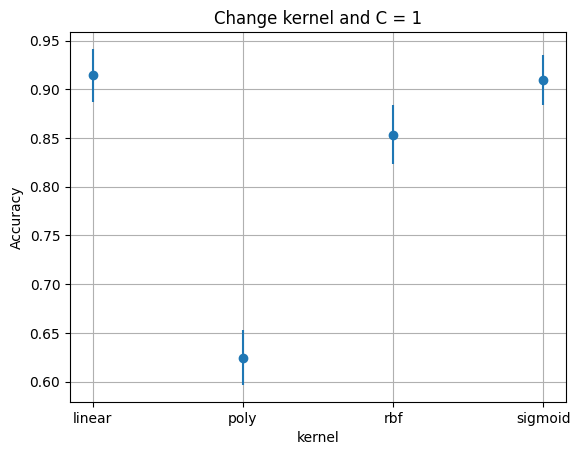

In [ ]:
title = "Change kernel and C = 1"
xlabel = "kernel"
X = []
Y = []
error = []
for kernel in tqdm(['linear', 'poly', 'rbf', 'sigmoid']):
# Với mỗi kernel được chọn,
# thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = svm.SVC(kernel = kernel, C = 1.0)
    mean, std = cross_validation(text_clf)
    X.append(kernel)
    Y.append(mean)
    error.append(std)
    
plot(title, xlabel, X, Y, error)
plt.show()

2. Choose C for SVM

100%|██████████| 5/5 [00:22<00:00,  4.53s/it]


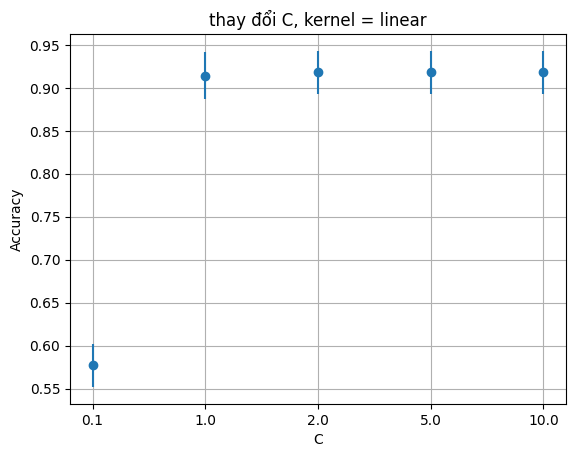

In [ ]:
title = "thay đổi C, kernel = linear"
xlabel = "C"
X = []
Y = []
error = []
for C in tqdm([.1, 1.0, 2.0, 5.0, 10.0]):
    # Với từng giá trị C nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = svm.SVC(kernel = 'linear', C = C)
    mean, std = cross_validation(text_clf)
    X.append(str(C))
    Y.append(mean)
    error.append(std)

plot(title, xlabel, X, Y, error)
plt.savefig
plt.show()

3. Use GridSearchCV

In [15]:
from sklearn.svm import SVC
param_grid = {
    'C': [.1, 1.0, 2.0, 5.0, 10.0], 
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': [0.0001, 0.001, 0.01, 0.1],}

grid_search = GridSearchCV(
    estimator = SVC(),
    param_grid = param_grid,
    cv = 10,
    scoring = 'accuracy',
    n_jobs = -1,
)

grid_search.fit(X_train, Y_train) 

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Best Parameters: {'C': 2.0, 'gamma': 0.0001, 'kernel': 'linear'}
Best CV Accuracy: 0.9178435444790585


**II. Random Forest Parameters**

1. Choose criterion for Random Forest

100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


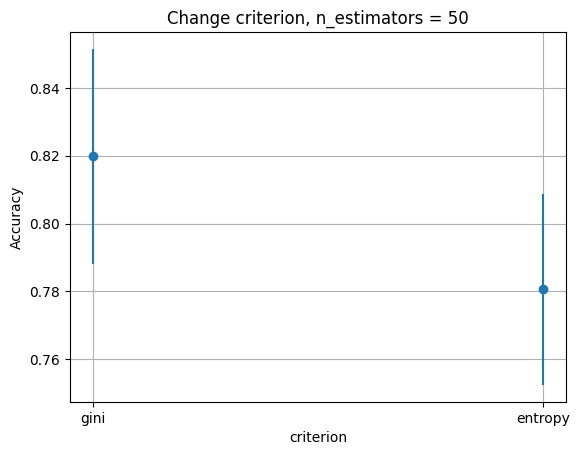

In [16]:
title = "Change criterion, n_estimators = 50"
xlabel = "criterion"
X = []
Y = []
error = []
for criterion in tqdm(["gini", "entropy"]):
    # Với mỗi criterion nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = RandomForestClassifier(criterion=criterion, n_estimators=50)
    mean, std = cross_validation(text_clf)
    X.append(str(criterion))
    Y.append(mean)
    error.append(std)

plot(title, xlabel, X, Y, error)
plt.show()

2. Choose n_estimators for Random Forest

100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


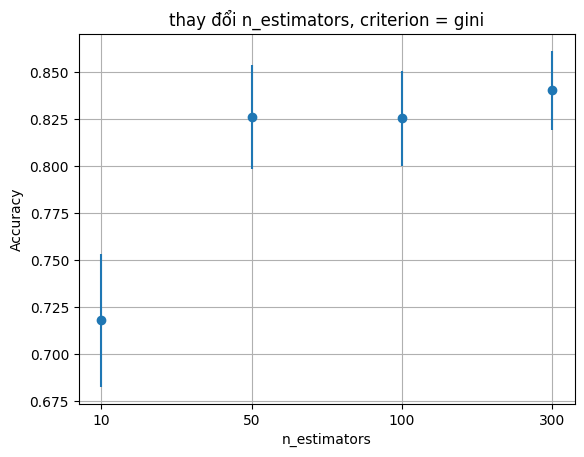

In [ ]:
title = "Change n_estimators, criterion = gini"
xlabel = "n_estimators"
X = []
Y = []
error = []
for n_estimators in tqdm([10, 50, 100, 300]):
    # Với từng giá trị n_estimators nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = RandomForestClassifier(criterion = 'gini', n_estimators = n_estimators)
    mean, std = cross_validation(text_clf)
    X.append(str(n_estimators))
    Y.append(mean)
    error.append(std)

plot(title, xlabel, X, Y, error)
plt.show()

**III. KNN Parameters**

100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


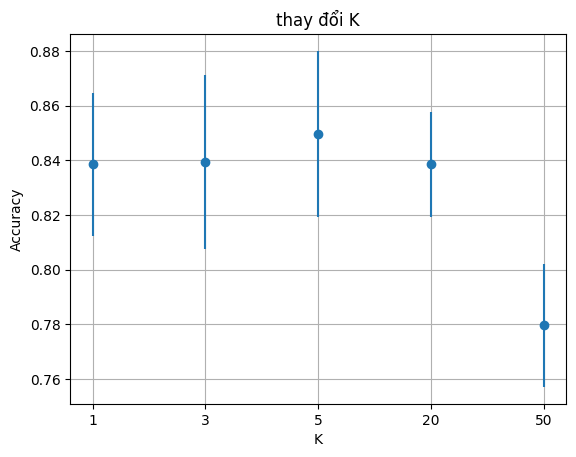

In [18]:
from sklearn.neighbors import KNeighborsClassifier
title = "thay đổi K"
xlabel = "K"
X = []
Y = []
error = []
for k in tqdm([1, 3, 5, 20, 50]):
    # Với từng giá trị k nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = KNeighborsClassifier(n_neighbors = k)
    mean, std = cross_validation(text_clf)
    X.append(str(k))
    Y.append(mean)
    error.append(std)

plot(title, xlabel, X, Y, error)
plt.show()

# Models Comparation

In [19]:
svm_ = svm.SVC(kernel = 'linear', C = 1.0)
rf = RandomForestClassifier(criterion = 'gini', n_estimators = 300)
knn = KNeighborsClassifier(n_neighbors = 5)
# Huấn luyện các mô hình trên tập dữ liệu train đầy đủ
svm_.fit(X_train, Y_train)
rf.fit(X_train, Y_train)
knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [20]:
# Kết quả dự đoán trên tập test
print(f'SVM: {accuracy_score(Y_test, svm_.predict(X_test))}')
print(f'RF: {accuracy_score(Y_test, rf.predict(X_test))}')
print(f'KNN: {accuracy_score(Y_test, knn.predict(X_test))}')

SVM: 0.9253731343283582
RF: 0.8283582089552238
KNN: 0.8395522388059702


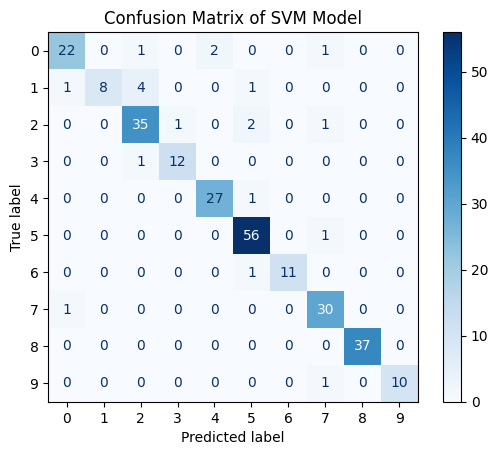

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix = confusion_matrix(Y_test, svm_.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = svm_.classes_)
disp.plot(cmap = 'Blues')
plt.title("Confusion Matrix of SVM Model")
plt.show()

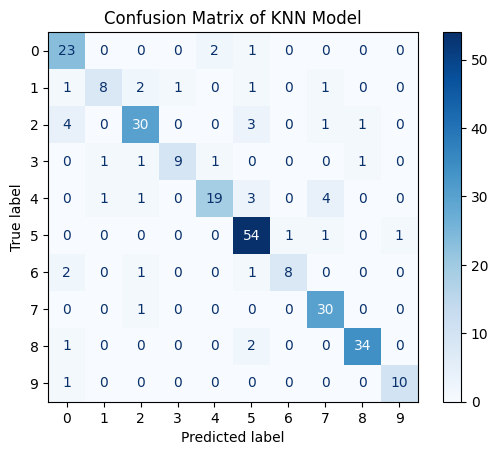

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix = confusion_matrix(Y_test, knn.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = knn.classes_)
disp.plot(cmap = 'Blues')
plt.title("Confusion Matrix of KNN Model")
plt.show()

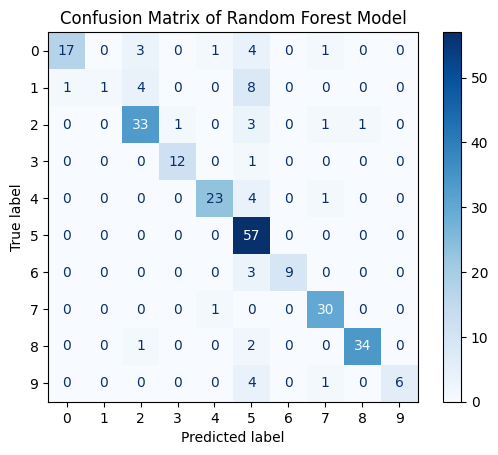

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix = confusion_matrix(Y_test, rf.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = rf.classes_)
disp.plot(cmap = 'Blues')
plt.title("Confusion Matrix of Random Forest Model")
plt.show()